## Scientific Computing 2024: Homework Assignment 1
Due Sunday October 13, 2024, 23:59

### Problem 1 (2 points)
Under assumptions of Amdahl's law, suppose that 75% of a program are perfectly parallelizable, and the rest is not parallelizable.
1. What is the maximum speedup achievable by parallelization?

$$S=\frac{1}{\frac{3}{4n}+\frac{1}{4}}=\frac{4n}{n+3}$$ where $n$ is the number of cores for parallel computing.

2. Suppose that we have obtained speedup 2 (by using a suitable number of processes). What is the efficiency of this parallelization?
$$S=\frac{4n}{n+3}=2$$the number of computation cores is $n=3$, so the efficiency of the parallelization is:
$$E=\frac{S}{n}=\frac{2}{3}≈67\%$$


### Problem 2 (2 points)
Write a Python or C/C++ program that uses **MPI reduce** to find the largest file in terms of the  number of lines among all .txt files in the working directory (only .txt files should be examined). The program must be callable in the form `mpirun -np <N> python linecount.py` (in the case of the Python version) or `mpirun -np <N> linecount.exe` (the C/C++ version), where `<N>` is the user-defined number of processes. The program is expected to first somehow distribute the files found in the current directory to the processes, then each process should count the lines in the files assigned to it, and finally the result should be MPI-reduced and printed out. The program only needs to output **the number of lines in the largest file**; no need to output the name of this file. The program must work correctly even if the number of files is not divisible by the number of processes.





In [4]:
!pip install mpi4py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.2/466.2 kB 10.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpi4py: filename=mpi4py-4.0.1-cp310-cp310-linux_x86_64.whl size=4266343 sha256=e7c9da3d86b2d43e68c3f3d09fa757fe3d546a3d84f8b55bf962d6b7d3905dcc
  Stored in directory: /root/.cache/pip/wheels/3c/ca/13/13218a83854023ccec184e3af482f0f038b434aa32c19afee8
Successfully built mpi4py


In [2]:
# create random txt files

import os
import random
import string
from pathlib import Path


def generate_random_string(length: int=10) -> str:
    """Generate a random string of fixed length."""
    letters = string.ascii_letters + string.digits
    return ''.join(random.choice(letters) for _ in range(length))


def create_random_files(num_files: int, min_lines: int, max_lines: int, output_dir: Path)->None:
    """Create a specified number of text files with random lines."""
    # Create output directory if it doesn't exist
    work_path = Path.cwd()
    folder = Path.cwd()/output_dir
    if not folder.exists():
        os.makedirs(work_path/output_dir)

    for i in range(num_files):
        # Generate a random number of lines
        num_lines = random.randint(min_lines, max_lines)

        # Create a filename
        filename = f"file_{i + 1}_{num_lines}.txt"
        filepath = folder/filename

        with open(filepath, 'w') as f:
            for _ in range(num_lines):
                # Write a random string as a line
                line = generate_random_string(random.randint(10, 30))  # Random length between 5 and 20
                f.write(line + '\n')

        print(f"Created {filepath} with {num_lines} lines.")


# Parameters
num_files = random.randint(100, 200)  # Random number of files between 1 and 10
min_lines = 1  # Minimum lines per file
max_lines = 2500  # Maximum lines per file
output_directory = 'random_files'  # Output directory

# Create the files
create_random_files(num_files, min_lines, max_lines, output_directory)

Created /content/random_files/file_1_1865.txt with 1865 lines.
Created /content/random_files/file_2_519.txt with 519 lines.
Created /content/random_files/file_3_4.txt with 4 lines.
Created /content/random_files/file_4_1828.txt with 1828 lines.
Created /content/random_files/file_5_966.txt with 966 lines.
Created /content/random_files/file_6_1121.txt with 1121 lines.
Created /content/random_files/file_7_334.txt with 334 lines.
Created /content/random_files/file_8_1033.txt with 1033 lines.
Created /content/random_files/file_9_1953.txt with 1953 lines.
Created /content/random_files/file_10_2123.txt with 2123 lines.
Created /content/random_files/file_11_567.txt with 567 lines.
Created /content/random_files/file_12_1426.txt with 1426 lines.
Created /content/random_files/file_13_1072.txt with 1072 lines.
Created /content/random_files/file_14_2244.txt with 2244 lines.
Created /content/random_files/file_15_246.txt with 246 lines.
Created /content/random_files/file_16_190.txt with 190 lines.
Cre

In [ ]:
# linecount.py
from pathlib import Path
from typing import TypeVar, Iterable
from mpi4py import MPI
import sys
import numpy as np

PathLike = TypeVar("PathLike", str, Path)

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
n_cores = comm.Get_size()

# count the number of lines
def count_lines(file_name: Path)->int:
  with open(file_name, "rb") as f:
      num_lines = sum(1 for _ in f)
      return num_lines

if rank == 0:
  folder = "random_files"
  # search files ending with ".txt"
  def search_txt(path: PathLike|str = None) -> Iterable:
      work_path = Path.cwd()
      work_dirs = work_path.parts
      if path is not None:
          dirs = Path(path).parts
          if dirs[0] not in work_dirs:
              data_path = work_path / path
          else:
              indx = work_dirs.index(dirs[0])
              data_path = Path(*work_dirs[0:indx], *dirs)
      else:
          data_path = work_path

      for full_path in data_path.iterdir():
          name = full_path.name
          if name.endswith('.txt'):
              yield full_path

  file_names = list(search_txt(folder))
else:
  file_names = None

file_names = comm.bcast(file_names, root=0)

tot_task = len(file_names)
tasks_perCore = tot_task//n_cores
res_tasks = tot_task%n_cores
file_name = file_names[tasks_perCore*rank:tasks_perCore*(rank+1)]

if res_tasks and rank<=res_tasks-1:
  file_res = file_names[tasks_perCore*n_cores:]
  file_name.append(file_res[rank])

local_max =  np.zeros(1, dtype=int)
glob_max = np.zeros(1, dtype=int)
for fi in file_name:
  num_line = count_lines(fi)
  if num_line>local_max:
    local_max[0] = num_line

comm.Reduce(local_max, glob_max, op=MPI.MAX, root=0)

if rank == 0:
  print(f"The number of lines in the largest file: {glob_max[0]}")


In [6]:
!sudo mpirun --allow-run-as-root --oversubscribe -np 8 python linecount.py

The number of lines in the largest file: 2472


### Problem 3 (2 points)
Solve the Distinct Substrings problem at Sphere online judge: http://www.spoj.com/problems/DISUBSTR/. Provide code passing the test of the judge. Explain how your code works and theoretically estimate the complexity of the algorithm (as $O(f(N))$, where $f(N)$ is some function of the length of the input string).


###Solution###
* Firstly, given a string, the code calculates the suffix array of the string with prefix doubling algorithm, with the complexity of $O(N \log^2N)$
* Secondly, calculate the LCP using the results of the previous step; the complexity of $O(N \log N)$
* Thirdly, calcualte the total number of distinct substrings; the compleixty is $O(N)$

So the overall time complexity of the algorithm is  $O(N \log^2N).$

In the first step, it enumerates a complete sets of suffix substrings, so the extra distinct substrings comes from its prefix substrings; each suffix substring can be generated extra L-1 number of prefix substrings, where L-1 is the lengith of prefix substrings, and L-1 is number of the extra distinct substrings can be generated. However, different suffix substrings may have common prefix. By substracting the number of the same prefix, i.e. LCP, and the results can be obtained by summing over all substrings.


In [1]:
import numpy as np
import random
import string

def invPerm(p):
  '''Invert the permutation p'''
  s = np.empty(p.size, p.dtype)
  s[p] = np.arange(p.size)
  return s


def getSA(A):
  if not type(A) is np.ndarray:
      A = np.array(list(A))
  N = len(A)
  M = int(np.ceil(np.log2(N)))+1   # number of iterations

  # auxiliary arrays; row m stores results after m'th step:

  # positions of sorted length-(2**m) sequences in A
  P = np.zeros((M,N), dtype=int)

  # rank (0, 1, etc.) of sorted length-(2**m) sequences after sorting
  Q = np.zeros((M,N), dtype=int)

  # rank of sorted length-(2**m) sequences at its starting position in A;
  # padded by 0 on the right
  R = np.zeros((M,3*N), dtype=int)

  for k in range(M):
      if k == 0:
          P[0] = np.argsort(A)
          Q[0][1:] = np.cumsum(A[P[0]][1:] != A[P[0]][:-1])
          R[0][:N] = Q[0][invPerm(P[0])]
      else:
          offset = 2**(k-1)
          r = np.lexsort((R[k-1, P[k-1]+offset], R[k-1, P[k-1]]))
          P[k] = P[k-1][r]
          # k'th rank increases iff (k-1)'th rank increases at least for one element of the pair
          Q[k][1:] = np.cumsum(np.logical_or(R[k-1][P[k]][1:] != R[k-1][P[k]][:-1],
                                        R[k-1][P[k]+offset][1:] != R[k-1][P[k]+offset][:-1]))
          R[k][:N] = Q[k][invPerm(P[k])]

          # early stopping if suffixes already fully sorted (max rank is N-1)
          if Q[k][-1] == N-1:
              break

  SA = P[k]
  return SA, P[:k+1], Q[:k+1], R[:k+1]


def getLCP(SA, R):
  (M, N) = R.shape
  LCP = np.zeros((len(SA)-1,),dtype=int)
  for m in range(M-1)[::-1]:
      t = (R[m][SA[1:]+LCP] == R[m][SA[:-1]+LCP]).astype(int)
      LCP += (2**m)*t
  return LCP



def generate_random_string(length):
  """Generate a random string of fixed length."""
  letters = string.ascii_uppercase
  return ''.join(random.choice(letters) for _ in range(length))


def generate_testSet(num_cases):
  for case_i in range(num_cases):
      yield generate_random_string(str_len)


if __name__ == "__main__":

  str_len = random.randint(1,1000)
  num_cases = 3
  testSet = generate_testSet(num_cases)

  for ii, A in enumerate(testSet):
      tot_num = 0
      L = len(A)
      SA, _, _, R = getSA(A)
      LCP = getLCP(SA, R)
      LCP = np.insert(LCP, 0, 0)
      for i in range(L):
          l = L - SA[i]
          tot_num += l - LCP[i]

      print("***********************")
      print(f"The string of CASE {ii} is: {A}")
      print(f"The total number of distinct substring of CASE {ii} is: {tot_num}")
      print("\n")


***********************
The string of CASE 0 is: IOBBIFFSZLMJOICGHBBNFZYGUSBKOVBPDRRNUJRNIOUZZANKCBTUHRLBALMGFCFCTBMWVYNLDNHXUKMRJHJSBZNTJHUPOANPBEUWEXUOPOCTQFVTTRBBZNIPOFZKTBKZFAJZZTLXPJIUSVZVORYMNKVLZBXJOMDVPGLLTCYHKLCNRHAJSIDHDCANBZMDCXEDYWRSTNLGNSDXZCVKEDRJWERZYGBQLVLTLUNRFGMQYIRCZLCNIORKENTVGAKSYYWIRUIGJIIMCLAQOJEJZZDTXIOJXTLAIWCDEHRJUBPXUFJSNKEPASWNWVOXJPXQDRSVGVRBKLZIXGYYGEXZMYRVEMTDOCTUJRUDEXXQLBEXTUFFWZRDDPNXLCHDEWPDGUQAZHPONRUZSFYBZTXYKGUUUYCMZTYIMLQYTKTXTYKDDEMWGAURQVUNMHVTVOJCSBCXUJFJQKLIYIBOICLCWRQYAWTAAWAMJSPBWKIXTOKGFFQBYBCYZXFZIJKXCMQHKWKNKAKANOZBFIQZLHSWKFMUCEFOXCQEUGTAXVJMQVWYDAMUHFLEJOPVOWHKNJLASAPBGZKMQNYEKCCFVYVNBORRPGAAWTRMPZBCSFIVAWZGIXVDVXVTEKMOXVEIMCYISZUWWJFKHAAOGKNSDXTMXFFLXFIPDYUEQBOLDORPHZXNBUHCRRMYRKIJOMXWZFLHEGZEPFLZSYZGPGCHGTVVQAINJEMSZXZNKNUJPSKISKCVJPEDASDIACZMWDDACKARLXBHZMJUOUIPAAIHHPUPABDIHNTCLQLDRCHETNYQXPPLSXJNAEFGOQDDDOEREGVFOLVQSRQXNUIBMOHNIMJWJZSTBBYAQJGVISIDDOHYQLSCVGEWQNOKURPMXYZDCYNAJXUYXJYISJLHA
The total number of distinct substring of CAS

### Problem 4 (2 points)
Suppose that we want to distribute $N$ personal projects to $N$ students. Assume that each student $(k)_{k=0}^{N-1}$ has a list of his/her preferences for the projects, expressed as a vector $\mathbf r_k$ of integer ranks assigned to each project. Ranks vary between 0 and $N-1$ without repetitions, the **lower** the rank the **more preferable** the project. (For example, the first student's ranks are $\mathbf r_0 = [2,1,0]$, the second's $\mathbf r_1 = [0,2,1]$ and the third $\mathbf r_2 = [0,1,2]$). We want to distribute the projects so as to maximize the total preference, i.e., if $n_k$ denotes the project assigned to the $k$'th student, we want to make $f = \sum_{k=0}^{N-1} \mathbf r_k[n_k]$ as small as possible. (In the example above the optimal distribution is $n_0=2, n_1=0, n_2=1$, which gives $f=1$).  
  * Come up with an algorithm optimizing the distribution and implement it in a Python or C/C++ program. The algorithm should accept the preference vectors and output a recommended distribution $(n_k)_{k=1}^N$. The algorithm need not find the best solution, but is expected to generally produce better solutions than would have been obtained by randomly distributing the projects. The algorithm should be reasonably fast, say run in not more than a few seconds for $N=30$.
  * Compare experimentally your algorithm with the trivial algorithm producing a random distribution. To this end, perform $M=1000$ experiments in each of which 1) random preference vectors for $N=30$ students and projects are generated; 2) the objective function $f$ is evaluated for both algorithms. After finishing all the experiments, plot the two respective distributions of the obtained $M$ values of $f$ and compute the mean values of $f$ for both algorithms.
  

### Solution:
To define a cost matrix for the assignment problem:

$ C = \begin{equation}
\begin{pmatrix}
  \textbf{r}_0  \\
  \textbf{r}_1  \\
  \vdots        \\
  \textbf{r}_{N-1} \\
\end{pmatrix}
\end{equation}
\textbf{I}$ = $\begin{equation}
\begin{pmatrix}
  \textbf{r}_0  \\
  \textbf{r}_1  \\
  \vdots        \\
  \textbf{r}_{N-1} \\
\end{pmatrix}
\end{equation}$=
$
\begin{equation}
\begin{pmatrix}
  r_{0,0}       & r_{0,1}   & r_{0,2}   & \cdots  & r_{0,N-1}  \\
  r_{1,0}       & r_{1,1}   & r_{1,2}   & \cdots  & r_{1,N-1}  \\
  \vdots  & \vdots  & \vdots  & \ddots  & \vdots \\
  r_{N-1,0}       & r_{N-1,1}   & r_{N-1,2}   & \cdots  & r_{N-1,N-1}  \\
\end{pmatrix}
\end{equation}
$

Let,
* $n_{ij} = 1$ reprents $j^{th}$ project assigned to $i^{th}$ student
* $n_{ij} = 0$ reprents $j^{th}$ project not assigned to $i^{th}$ student

The loss function can be written,

$$f=\sum_{k=0}^{N-1} \mathbf r_k \mathbf n_k=\sum_{i=0}^{N-1} \sum_{j=0}^{N-1}r_{ij}n_{ij}$$

where $n_{ij}=\{0,1\}$, and subjects to,

$$\sum_{i=0}^{N-1} n_{ij} = 1 $$ $$\sum_{j=0}^{N-1} n_{ij} = 1 $$

To solve

$\underset{n_{ij}}{\mathrm{argmin}} f$


In [7]:
import numpy as np
import time
from itertools import permutations
from scipy.optimize import linear_sum_assignment


# # brute force method

# def project_Machine(r, N):
#   indicators = np.eye(N, dtype=np.int32)
#   ps = list(permutations(range(N)))
#   identifier = None
#   min = N**2
#   for i, ps_i in enumerate(ps):
#       assign = indicators[:,ps_i]
#       penalty = np.sum(assign*r)
#       if penalty < min:
#           min = penalty
#           identifier = i
#   return min, ps[identifier]


# def invPerm(p):
#   '''Invert the permutation p'''
#   s = np.empty(p.size, p.dtype)
#   s[p] = np.arange(p.size)
#   return s


# # test 1
# # preferable rank
# N = 3
# r0 = np.array([2, 1, 0], dtype=np.int32)
# r1 = np.array([0, 2, 1], dtype=np.int32)
# r2 = np.array([0, 1, 2], dtype=np.int32)
# r = np.array([r0, r1, r2])
# t1 = time.perf_counter()
# f, dist = project_Machine(r, N)
# t2 = time.perf_counter()
# brute force method
# print(f"The minimum penalty f={f}")
# print(f"The optimal distribution: {invPerm(np.array(dist))}")
# print(f"Calculation time: {t2-t1}")

# # test 2
# number of students/projects
N = 30
# generate cost matrix
r = np.array([np.random.permutation(N).tolist() for _ in range(N)])

t1 = time.perf_counter()
row_ind, col_ind = linear_sum_assignment(r)
# cost function
f = r[row_ind, col_ind].sum()
t2 = time.perf_counter()
print(f"The minimum penalty f={f}")
print(f"The student index: {row_ind}")
print(f"The project index: {col_ind}")
print(f"Calculation time: {t2-t1}")




The minimum penalty f=32
The student index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
The project index: [ 7 15 27 10  0 14  5 19 26 20 13  6 16  1  8 24 29  3 25 23 17  2 28 11
 21 12  4  9 22 18]
Calculation time: 0.00034664100166992284




Mean value of objective function f with scipy linear programming solver: 22.851
Mean value of objective function f with random assignment solver: 435.615




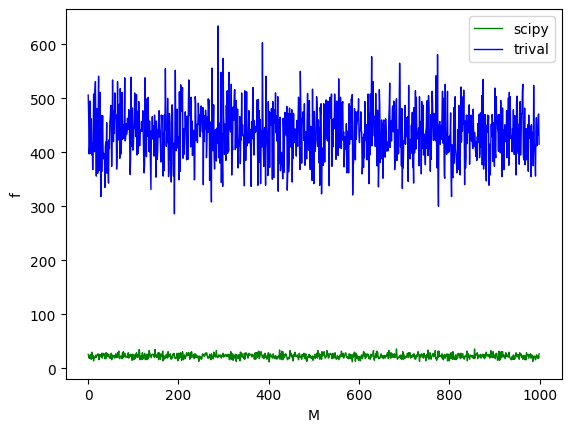

In [17]:
from matplotlib import pyplot as plt

# naive random method
def rand_pick(r, N):
  penalty=0
  l = np.arange(N,dtype=np.int32)
  rd_ind = np.random.permutation(l)
  for indi, ri in enumerate(r):
    penalty+=ri[rd_ind[indi]]
  return penalty


# experiment
M =1000
N=30

f_tri = []
f_sci = []
for _ in range(M):
  costMatrix = np.array([np.random.permutation(N).tolist() for _ in range(N)])
  row_ind, col_ind = linear_sum_assignment(costMatrix)
  f1 = costMatrix[row_ind, col_ind].sum()
  f_sci.append(f1)
  f2 = rand_pick(costMatrix,N)
  f_tri.append(f2)

mean_sci = np.array(f_sci).mean()
mean_tri = np.array(f_tri).mean()

fig, ax1 = plt.subplots(1, 1)
ax1.plot(f_sci,'g-',linewidth=1, label="scipy")
ax1.plot(f_tri,'b-',linewidth=1, label="trival")
ax1.legend()
ax1.set_ylabel("f")
ax1.set_xlabel("M")

print("\n")
print(f"Mean value of objective function f with scipy linear programming solver: {mean_sci}")
print(f"Mean value of objective function f with random assignment solver: {mean_tri}")
print("\n")

### Problem 5 (2 points)
Suppose that we have developed an algorithm that is supposed to generate independent (quasi-)random numbers uniformly distributed in the interval $[0,1]$. To test our algorithm, we perform a series of experiments. In each experiment, we generate $N=10^3$ numbers $(x_n)_{n=1}^N$ with our algorithm, and compute the minimum distance $r=\min_{1 \le n < m\le N}|x_n-x_m|$ between them. We observe that in more than 99% of such experiments we obtain $r < 10^{-5}$. Does this observation contradict the hypothesis of generating independent uniformly distributed random numbers? Explain your answer.

#### solution
No, this observation doesn't contradict the hypothesis of generating independent uniformaly distributed random numbers. According to the theory, two uniformally distributed random variables, their minimum distance $r$ following poisson distribution $\approx exp(-r)$



In [104]:
import numpy as np

# generate the minimum distance
def generator(N: int)->float:
  rv = np.random.uniform(0,1,N)
  rv_sorted = np.sort(rv)
  delta = rv_sorted[1:] - rv_sorted[:-1]
  return delta.min()

# generating an array of the minimum distance
def occurence(N: int, M: int, repeat: int)->tuple[list, list]:
  r_min = 10**-5
  occur=[]
  delta=[]
  for _ in range(repeat):
    count=0.0
    for _ in range(M):
      delta_min = generator(N)
      delta.append(delta_min)
      if delta_min < r_min:
        count+=1.0
    occur.append(count/M)

  return occur, delta

Text(0, 0.5, 'frequency')

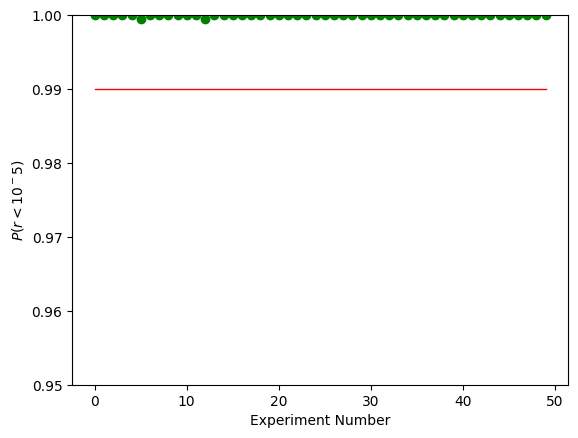

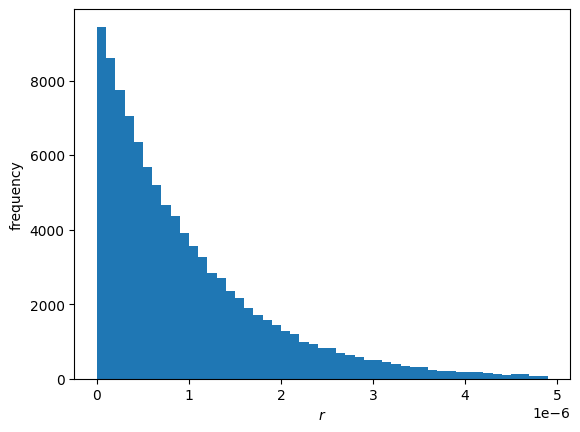

In [134]:
from matplotlib import pyplot as plt

# experiment
N = 10**3 # number of Uniform distribution points
M = 2000  # number of uniform distributions points list
repeat = 50 # repeat the experiment 50 times
occ, delta = occurence(N, M, repeat)


x = range(repeat)


fig1, ax1 = plt.subplots(1, 1)
ax1.plot(x, occ, 'go',linewidth=1)
ax1.plot(x, [0.99 for _ in x], 'r-',linewidth=1)
ax1.set_ylabel(r"$P(r<10^-5)$")
ax1.set_xlabel("Experiment Number")
plt.ylim([0.95,1])


fig2, ax2 = plt.subplots(1, 1)
ax2.hist(delta, bins=(10**-7)*np.arange(50))

ax2.set_xlabel("$r$")
ax2.set_ylabel(r"frequency")
